<a href="https://colab.research.google.com/github/stswee/ECE219/blob/main/ECE219_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [47]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Set random seeds
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
# Load in dataset
df = pd.read_csv("Project1-ClassificationDataset.csv")
# df.head()

## Geting familiar with the dataset

### Question 1

In [3]:
# Overview
numrows = df.shape[0]
numcols = df.shape[1]

print("There are", numrows, "rows in the dataset.")
print("There are", numcols, "columns in the dataset.")

There are 3476 rows in the dataset.
There are 8 columns in the dataset.


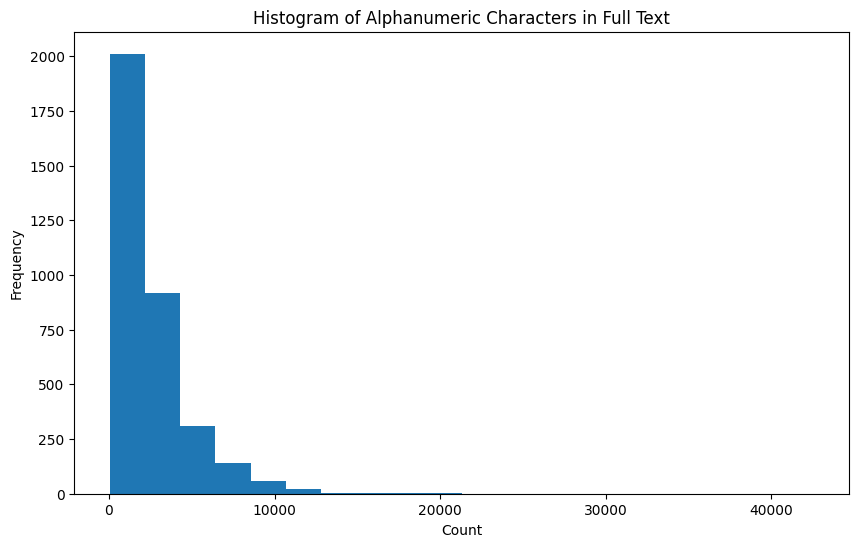

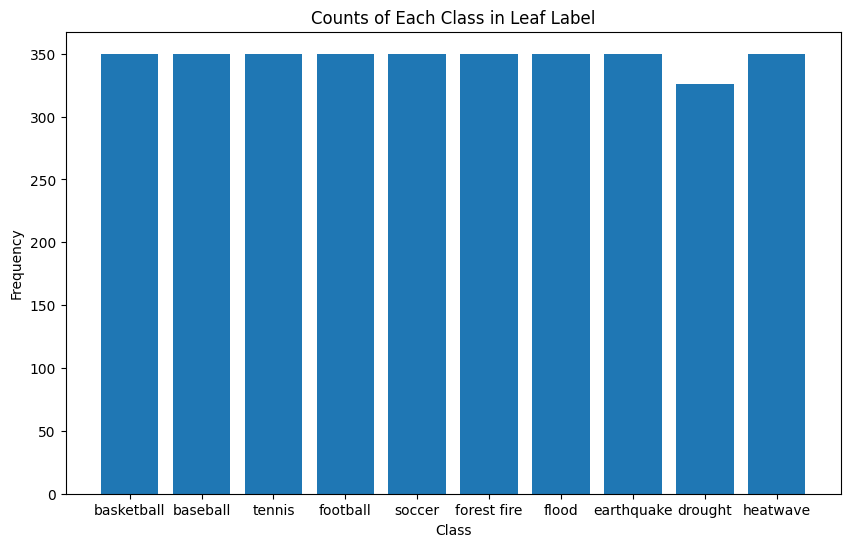

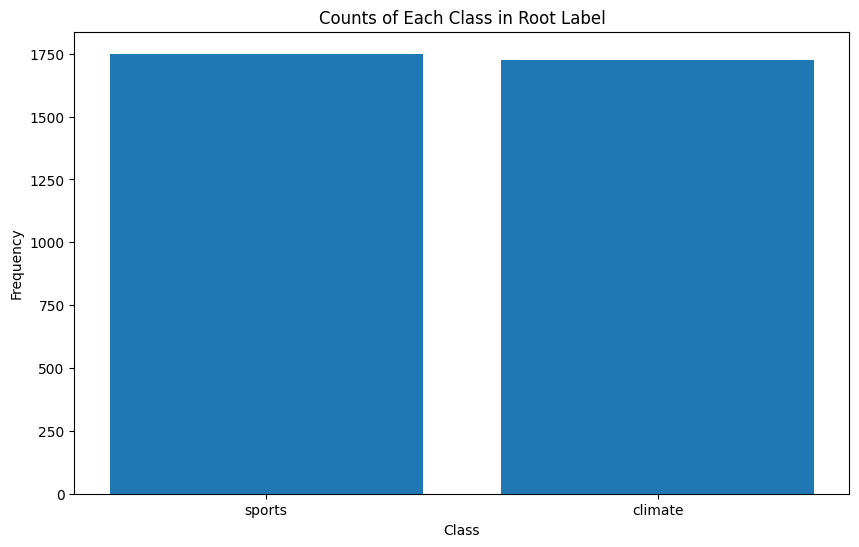

In [4]:
# Histograms
def count_alphanumeric(text = str) -> int:
  """
  Counts the number of alphanumeric characters in a string.

  Parameters
  ----------
  text : str
    The string to count the alphanumeric characters in.

  Returns
  -------
  int
    The number of alphanumeric characters in the string.
  """
  count = 0
  for char in text:
    if char.isalnum():
      count += 1
  return count

def count_classes(df = pd.DataFrame, col = str) -> list:
  """
  Counts the number of classes in a column of a dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to count the classes in.
  col : str
    The column to count the classes in.

  Returns
  -------
  2 lists
    A list of classes and a list of the counts of classes in the column.
  """
  classes = df[col].unique()
  counts = []
  for unique_class in classes:
    counts.append(df[col].str.contains(unique_class).sum())
  return classes, counts

# Keep track of counts of alphanumeric characters
count_alphanumeric_full_text = []
for text in df['full_text']:
  count_alphanumeric_full_text.append(count_alphanumeric(text))

# Keep track of counts of each class
classes_leaf_label, count_classes_leaf_label = count_classes(df, 'leaf_label')
classes_root_label, count_classes_root_label = count_classes(df, 'root_label')

# Histogram of alphanumeric characters
plt.figure(figsize=(10, 6))
plt.hist(count_alphanumeric_full_text, bins = 20)
plt.title('Histogram of Alphanumeric Characters in Full Text')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

# Histogram of counts of each class in leaf_label
plt.figure(figsize=(10, 6))
plt.bar(classes_leaf_label, count_classes_leaf_label)
plt.title('Counts of Each Class in Leaf Label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Histogram of counts of each class in root_label
plt.figure(figsize=(10, 6))
plt.bar(classes_root_label, count_classes_root_label)
plt.title('Counts of Each Class in Root Label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

The number of alpha-numeric characters per data point appears to follow an exponential distribution with nearly all documents containing 10000 or fewer alpha-numeric characters. There also appears to be a balanced set of classes for the leaf_label column with only drought having a slightly lower frequency. For the root_label column, the sports and climate classes are nearly balanced with sports having a marginally higher frequency.

## Binary Classification

### 1. Splitting the entire dataset into training and testing data

In [5]:
# Set seeds
np.random.seed(42)
random.seed(42)

# Split dataset
train, test = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

### Question 2

In [6]:
# Count number of rows in train and test
num_train = train.shape[0]
num_test = test.shape[0]

# Display results
print("Number of rows in train:", num_train)
print("Number of rows in test:", num_test)


Number of rows in train: 2780
Number of rows in test: 696


### 2. Feature Extraction

### Question 3

In [37]:
# Preprocessing functions
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_stopwords(df = pd.DataFrame, col = str, mindf = int) -> pd.DataFrame:
  """
  Removes stopwords from the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to remove stopwords from.
  col : str
    The column to remove stopwords from.

  Returns
  -------
  pd.DataFrame
    The dataframe with stopwords removed.
  """

  # Helper function to filter out stopwords
  def filter_sentence(sentence = str, vocab = set) -> str:
    """
    Filters the sentence based on the vocabulary.

    Parameters
    ----------
    sentence : str
      The sentence to filter.
    vocab : set
      The vocabulary to filter the sentence with.

    Returns
    -------
    str
      The filtered sentence.
    """

    # Tokenize sentence
    words = sentence.split()

    # Get filtered words
    filtered_words = [word for word in words if word.lower() in vocab]

    # Reconstruct sentence
    return ' '.join(filtered_words)

  # Initialize CountVectorizer
  count_vectorizer = CountVectorizer(stop_words = 'english', min_df = mindf)
  fittransform = count_vectorizer.fit_transform(df[col])

  # Get vocabulary
  vocab = set(count_vectorizer.get_feature_names_out())

  # Remove stopwords
  df[col] = df[col].apply(lambda x: filter_sentence(x, vocab))
  return df

def remove_numbers(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Removes numbers from the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to remove numbers from.
  col : str
    The column to remove numbers from.

  Returns
  -------
  pd.DataFrame
    The dataframe with numbers removed.
  """

  # Remove numbers
  df[col] = df[col].apply(lambda x: re.sub(r'\b\d+\b', '', x))
  return df

def remove_punctuation(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Remove punctuation from the text

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to remove punctuation from.
  col : str
    The column to remove punctuation from.

  Returns
  -------
  pd.DataFrame
    The dataframe with punctuation removed.
  """

  # Use translate to remove punctuation
  translator = str.maketrans('', '', string.punctuation)
  df[col] = df[col].apply(lambda x: x.translate(translator))
  return df

def lemmatize(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Lemmatizes the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to lemmatize.
  col : str
    The column to lemmatize.

  Returns
  -------
  pd.DataFrame
    The dataframe after lemmatization.
  """

  # Helper function for getting part of speech
  def get_wordnet_pos(tag):
    """
    Maps POS tags to WordNet POS tags.

    Parameters
    ----------
    tag : str
      The POS tag to map.

    Returns
    -------
    str
      The mapped POS tag.
    """
    if tag.startswith('J'):  # Adjective
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verb
        return wordnet.VERB
    elif tag.startswith('N'):  # Noun
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverb
        return wordnet.ADV
    else:
        return None

  # Helper function to lemmatize
  def lemmatize_pos(text = str) -> str:
    """
    Lemmatizes the text with part of speech.

    Parameters
    ----------
    text : str
      The text to lemmatize.

    Returns
    -------
    str
      The lemmatized text.
    """

    # Tokenize sentence
    tokens = word_tokenize(text)

    # Get part of speech tags
    pos_tags = pos_tag(tokens)

    # Keep list of lemmatized words
    lemmatized_words = []

    # Lemmatize each word
    for word, pos in pos_tags:

      # Get part of speech. For missing part of speech, assume noun
      wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
      lemmatized_words.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    # Join words
    return ' '.join(lemmatized_words)

  # Initialize lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Apply lemmatization
  df[col] = df[col].apply(lemmatize_pos)
  return df

def stemming(df = pd.DataFrame, col = str) -> pd.DataFrame:
  """
  Stems the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to stem.
  col : str
    The column to stem.

  Returns
  -------
  pd.DataFrame
    The dataframe after stemming.
  """

  # Helper function for stemming
  def stem(text = str) -> str:
    """
    Stems the text.

    Parameters
    ----------
    text : str
      The text to stem.

    Returns
    -------
    str
      The stemmed text.
    """

    # Tokenize sentence
    tokens = word_tokenize(text)

    # Get stemmed words
    stemmed_words = [stemmer.stem(word) for word in tokens]

    # Join words
    return ' '.join(stemmed_words)

  # Initialize stemmer
  stemmer = PorterStemmer()

  # Apply stemming function
  df[col] = df[col].apply(stem)
  return df

In [38]:
def preprocessing(df = pd.DataFrame, col = str, preprocess = list, mindf = int) -> pd.DataFrame:
  """
  Preprocesses the text.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to preprocess.
  col : str
    The column to preprocess.
  preprocess : list
    The list of preprocessing functions to apply.
  mindf : int
    The minimum document frequency to use for CountVectorizer.

  Returns
  -------
  pd.DataFrame
    The dataframe after preprocessing.
  """

  # Must have clean function first
  if preprocess[0] != clean:
    print("Clean function must be first")

  # Apply preprocessing functions
  for func in preprocess:
    if func == clean:
      df = df[col].apply(clean).to_frame()
    elif func == remove_punctuation:
      df = remove_punctuation(df, col)
    elif func == remove_numbers:
      df = remove_numbers(df, col)
    elif func == remove_stopwords:
      df = remove_stopwords(df, col, mindf)
    elif func == lemmatize:
      df = lemmatize(df, col)
    elif func == stemming:
      df = stemming(df, col)
    else:
      print("Invalid preprocessing function")
  return df

def tfidf_process(df = pd.DataFrame, col = str, matrix = bool) -> pd.DataFrame:
  """
  Processes the text using TF-IDF.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to process.
  col : str
    The column to process.
  matrix : bool
    Whether to return the TF-IDF matrix or the dataframe with the TF-IDF matrix.

  Returns
  -------
  sparse matrix or pd.DataFrame
    The TF-IDF matrix or the dataframe with the TF-IDF matrix.
  """

  # Initialize TF-IDF vectorizer
  tfidf_vectorizer = TfidfVectorizer()

  # Fit and transform data
  tfidf_matrix = tfidf_vectorizer.fit_transform(df[col])

  # Convert result to dataframe if requested
  if matrix:
    return tfidf_matrix
  else:
    return pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

In [40]:
### The order of the following can be changed as needed
# Current iteration takes ~60-90s to run on CPU (almost all time spent on lemmatization)
# NLTK does not use GPU (will need something like SpaCy)

# Adjust preprocessing_functions and min_df
preprocessing_functions = [clean, remove_punctuation, remove_numbers, remove_stopwords, lemmatize]
min_df = 3

# Preprocess data
X_train = preprocessing(train, 'full_text', preprocessing_functions, min_df)
X_test = preprocessing(test, 'full_text', preprocessing_functions, min_df)

# Get TF-IDF matrices
X_train_tfidf = tfidf_process(X_train, 'full_text', False)
X_test_tfidf = tfidf_process(X_test, 'full_text', False)

In [45]:
# Experiment in speed and TF-IDF size for lemmatize vs. stemming
# Adjust preprocessing_functions and min_df
preprocessing_functions = [clean, remove_punctuation, remove_numbers, remove_stopwords, lemmatize]
min_df = 3

# Preprocess data
start = time.time()
X_train_lem = preprocessing(train, 'full_text', preprocessing_functions, min_df)
end = time.time()
X_train_lem_tfidf = tfidf_process(X_train_lem, 'full_text', False)
print("Time taken for lemmatization on training set: " + str(round(end - start, 2)) + " seconds.")
print("Size of TF-IDF matrix on training set: " + str(X_train_lem_tfidf.shape[1]))
print()

start = time.time()
X_test_lem = preprocessing(test, 'full_text', preprocessing_functions, min_df)
end = time.time()
X_test_lem_tfidf = tfidf_process(X_test_lem, 'full_text', False)
print("Time taken for lemmatization on test set: " + str(round(end - start, 2)) + " seconds.")
print("Size of TF-IDF matrix on test set: " + str(X_test_lem_tfidf.shape[1]))
print()

# Adjust preprocessing_functions and min_df
preprocessing_functions = [clean, remove_punctuation, remove_numbers, remove_stopwords, stemming]
min_df = 3

# Preprocess data
start = time.time()
X_train_stem = preprocessing(train, 'full_text', preprocessing_functions, min_df)
end = time.time()
X_train_stem_tfidf = tfidf_process(X_train_stem, 'full_text', False)
print("Time taken for stemming on training set: " + str(round(end - start, 2)) + " seconds.")
print("Size of TF-IDF matrix on training set: " + str(X_train_stem_tfidf.shape[1]))
print()

start = time.time()
X_test_stem = preprocessing(test, 'full_text', preprocessing_functions, min_df)
end = time.time()
X_test_stem_tfidf = tfidf_process(X_test_stem, 'full_text', False)
print("Time taken for stemming on test set: " + str(round(end - start, 2)) + " seconds.")
print("Size of TF-IDF matrix on test set: " + str(X_test_stem_tfidf.shape[1]))
print()

Time taken for lemmatization on training set: 57.21 seconds.
Size of TF-IDF matrix on training set: 16519

Time taken for lemmatization on test set: 14.18 seconds.
Size of TF-IDF matrix on test set: 7532

Time taken for stemming on training set: 31.59 seconds.
Size of TF-IDF matrix on training set: 11685

Time taken for stemming on test set: 5.68 seconds.
Size of TF-IDF matrix on test set: 5440



In [39]:
# Experiment with changing min_df
# Took about ~10 min to complete

preprocessing_functions = [clean, remove_punctuation, remove_numbers, remove_stopwords, lemmatize]
min_dfs = [3, 4, 5, 6, 7, 8, 9, 10]

for min_df in min_dfs:
  X_train = preprocessing(train, 'full_text', preprocessing_functions, min_df)
  X_test = preprocessing(test, 'full_text', preprocessing_functions, min_df)

  X_train_tfidf = tfidf_process(X_train, 'full_text', False)
  X_test_tfidf = tfidf_process(X_test, 'full_text', False)

  # Print number of columns in tfidf
  print("Train: Number of columns in tfidf for min_df = " + str(min_df) + ": " + str(X_train_tfidf.shape[1]))
  print("Test: Number of columns in tfidf for min_df = " + str(min_df) + ": " + str(X_test_tfidf.shape[1]))
  print()


Train: Number of columns in tfidf for min_df = 3: 16519
Test: Number of columns in tfidf for min_df = 3: 7532

Train: Number of columns in tfidf for min_df = 4: 13655
Test: Number of columns in tfidf for min_df = 4: 5995

Train: Number of columns in tfidf for min_df = 5: 11813
Test: Number of columns in tfidf for min_df = 5: 5093

Train: Number of columns in tfidf for min_df = 6: 10456
Test: Number of columns in tfidf for min_df = 6: 4450

Train: Number of columns in tfidf for min_df = 7: 9469
Test: Number of columns in tfidf for min_df = 7: 3904

Train: Number of columns in tfidf for min_df = 8: 8708
Test: Number of columns in tfidf for min_df = 8: 3513

Train: Number of columns in tfidf for min_df = 9: 8084
Test: Number of columns in tfidf for min_df = 9: 3168

Train: Number of columns in tfidf for min_df = 10: 7493
Test: Number of columns in tfidf for min_df = 10: 2930



### TODO: Verify answers with experiments (i.e. change order of preprocessing steps for before/after lemmatizing)

**Pros and Cons of lemmatization vs. stemming**

The advantage of lemmatization is that it accounts for context and is more robust by using morphological information. This allows lemmatization to be relatively more accurate. Stemming takes a simpler approach by removing suffixes (i.e. the rightmost letters) to find the root word. While this approach is simpler and allows stemming to be faster than lemmatization, stemming is generally less accurate.

In short, the tradeoff between between lemmatization and stemming is between speed (stemming preferred) and accuracy (lemmatization preferred).

Per our experiment above, stemming is about twice as fast as lemmatization and leads to a smaller dictionary size. The dictionary size was inferred from fewer columns in the TF-IDF matrix.

**Changing minimum document frequency**

Increasing the minimum document frequency means that words will have to appear in more documents to be kept. This higher threshold leads to fewer words being kept, ultimately decreasing the number of columns in the TF-IDF matrix.

Per our experiment above, using a min_df between 3 and 6 yields approximately 10^4 columns whereas using a min_df between 7 and 10 yields approximately 10^3 columns.

**Before and after lemmatizing**

Performing additional preprocessing steps before or after lemmatizing comes down to choosing between retaining context and computation time. Removing stopwords, punctuations, and numbers before lemmatizing will require less computational overhead using lemmatizing. Keeping stopwords, punctuations, and numbers will allows context to be retained for lemmatization. In general, if stopwords, punctuations, and numbers contribute little to the context of the document with respect to the classes the documents are a part of, then it may be fine to remove them prior to lemmatization.

In the context of this project, we choose to perform lemmatization after removing stopwords, punctuations, and numbers. We assume that stopwords, punctuations, and numbers contribute little to the context (i.e. they do not help distinguish between whether a document is about sports or climate).



### 3. Dimensionality Reduction

### Question 4

In [46]:
### The order of the following can be changed as needed
# Current iteration takes ~60-90s to run on CPU (almost all time spent on lemmatization)
# NLTK does not use GPU (will need something like SpaCy)

# Adjust preprocessing_functions and min_df
preprocessing_functions = [clean, remove_punctuation, remove_numbers, remove_stopwords, lemmatize]
min_df = 3

# Preprocess data
X_train = preprocessing(train, 'full_text', preprocessing_functions, min_df)
X_test = preprocessing(test, 'full_text', preprocessing_functions, min_df)

# Get TF-IDF matrices
X_train_tfidf = tfidf_process(X_train, 'full_text', False)
X_test_tfidf = tfidf_process(X_test, 'full_text', False)

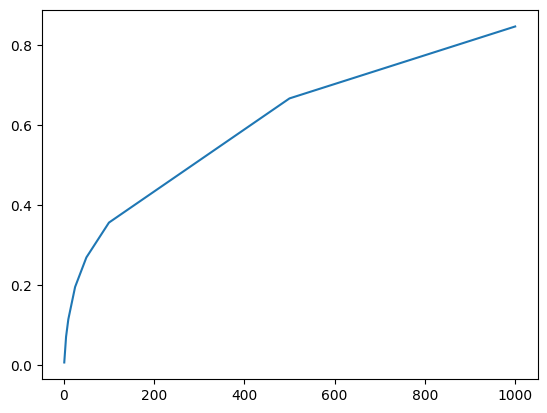

In [50]:
# Experiment with different explained variance ratios
# Takes about 2 minutes to run
k = [1, 5, 10, 25, 50, 100, 500, 1000]
total_explained_variance = []
for i in k:
  svd = TruncatedSVD(n_components = i)
  lsa_matrix = svd.fit_transform(X_train_tfidf)
  explained_variance_ratio = svd.explained_variance_ratio_
  total_explained_variance.append(sum(explained_variance_ratio))

# Plot explained variance ratio
plt.plot(k, total_explained_variance)
plt.show()

Let k be the number of the largest singular values of the term-document TF-IDF matrix. The plot indicates that a higher k leads to a greater explained variance ratio. The plot is concave down, suggesting diminishing returns in increasing explained variance for greater k.

In [49]:
# TODO: Perform LSI and NMF using k = 25, then determine residual MSE error

Explained variance ratio: [0.00579711 0.02335471]
Total explained variance: 0.029151817967345194


In [ ]:
# TODO: reduce test data by right multiplying the TF-IDF matrix for the test set by the k principle components of the TF-IDF matrix for the train set